In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pandas as pd
from scipy.spatial.distance import jensenshannon
import numpy as np
from datetime import datetime
from src import utils, plotting, scoring
from sklearn.metrics import f1_score

Dados

In [3]:
# Parâmetros
n_samples = 100000 
n_features = 20  
n_informative = 2   # Número de características informativas
n_redundant = 2    # Número de características redundantes
weights = [0.2, 0.8]  # Desbalanceamento

# Gerar os dados
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features, 
                           n_informative=n_informative, 
                           n_redundant=n_redundant, 
                           flip_y=0.05, 
                           random_state=42,
                           )

# Adicionar coluna com duas categorias
category_col = np.random.choice([0, 1], size=n_samples, p=weights)

# Adicionar coluna com diversas categorias (por exemplo, 5 categorias)
diverse_category_col = np.random.choice([0, 1, 2, 3, 4], size=n_samples)


In [4]:
# Criar DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
df['discrete_0'] = category_col
df['discrete_1'] = diverse_category_col
df['target'] = y
df['datetime'] = utils.generate_random_dates_within_interval(datetime(2021, 1, 1), 4, n_samples)
df_train = df[df["datetime"] < '2024']
df_reference = df[(df["datetime"] >= '2024-01-01') & (df["datetime"] < '2024-07-01')].copy()
df_test = df[(df["datetime"] >= '2024-07-01')].copy()

In [5]:
X_train = df_train[df_train.columns[:-2]]
y_train = df_train["target"]

In [6]:
rf = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True,
                       random_state=42)

df_test

In [7]:
y_prob = rf.predict_proba(df_test[df_test.columns[:-2]])
y_pred = rf.predict(df_test[df_test.columns[:-2]])
y_prob = y_prob[np.arange(len(df_test)), y_pred]
df_test["y_prob"] = y_prob
df_test["prediction"] = y_pred

df_reference

In [8]:
y_prob = rf.predict_proba(df_reference[df_reference.columns[:-2]])
y_pred = rf.predict(df_reference[df_reference.columns[:-2]])
y_prob = y_prob[np.arange(len(y_prob)), y_pred]
df_reference["y_prob"] = y_prob
df_reference["prediction"] = y_pred

In [9]:
result = scoring.metric_by_time_period(df_reference, 'W', 'target', 'prediction', f1_score)

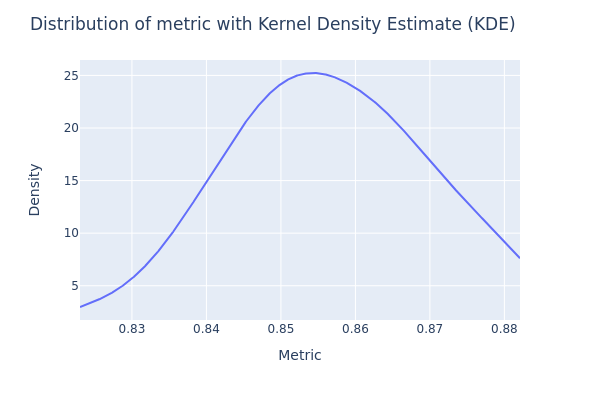

In [10]:
plotting.kde(result, 'metric', fig_type="png")


In [11]:
reference_metrics = scoring.reference_metrics_by_period(df_reference, "W", "target", "prediction", f1_score)

In [12]:
reference_metrics

{'ci_lower': 0.847558990100247,
 'ci_upper': 0.8632556566862514,
 'mean': 0.8560840015955162,
 'lower_threshold': 0.8137383967030402,
 'upper_threshold': 0.8984296064879923}

In [13]:
reference_score = scoring.metric_by_time_period(df_reference, 'W', 'target', 'prediction')

# Reference

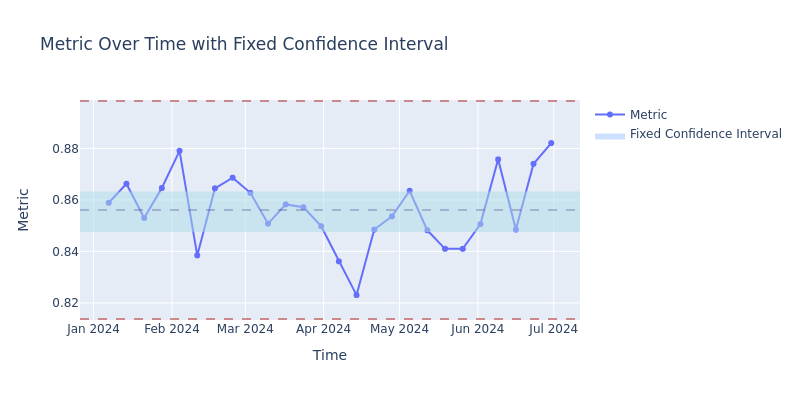

In [14]:
plotting.performance_by_time(reference_metrics, reference_score, fig_type="png")

# Analysis

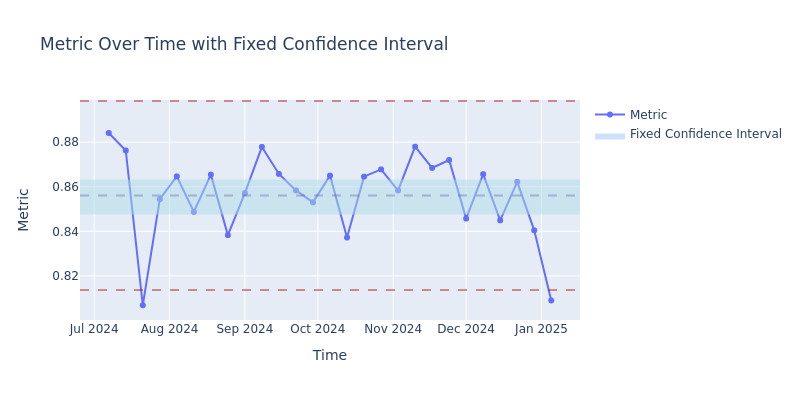

In [15]:
analysis_score = scoring.metric_by_time_period(df_test, 'W', 'target', 'prediction', f1_score)
plotting.performance_by_time(reference_metrics, analysis_score, fig_type="png")

# Discrete Data Drift

In [208]:
class CategoricalDriftDetector:
    def __init__(self, 
                 reference_data, 
                 column_name, 
                 period, 
                 column_timestamp, 
                 distance_function='l_infinity',
                 statistic=np.mean, 
                 confidence_level=0.997,
                 n_resamples=1000,
                 random_state=42):
        self.reference_data = reference_data
        self.column_name = column_name
        self.period = period
        self.column_timestamp = column_timestamp
        self.reference_distribution = self._calculate_distribution(reference_data, period, column_timestamp)
        self.reference_distance = self.generate_distance(distance_function)
        self.statistics = self._statistics_by_period(self.reference_distance, statistic, confidence_level, n_resamples, random_state)
        
    def _calculate_distribution(self, df, period, column_timestamp):
        grouped = (
            df.groupby(pd.Grouper(key=column_timestamp, freq=period)).apply(
            lambda x: x[self.column_name].value_counts(normalize=True))
            .rename("metric")
            .reset_index()
            .rename(columns={"level_1": self.column_name}))

        grouped = grouped.set_index([column_timestamp, self.column_name]).unstack(fill_value=0)

        return grouped

    def _l_infinity_distance(self, a, b):
        return np.max(np.abs(a - b), axis=1).rename("metric")

    def _jensenshannon_distance(self, a, b):
        js = jensenshannon(a, b, axis=1)
        return pd.Series(js, index=a.index, name="metric")

    def generate_distance(self, distance_function):
        if distance_function == "l_infinity":
            distance_value = self._l_infinity_distance(self.reference_distribution, self.reference_distribution.shift())
        if distance_function == "jensenshannon":
            distance_value =  self._jensenshannon_distance(self.reference_distribution, self.reference_distribution.shift())
        return distance_value.reset_index().loc[1:]

    def _statistics_by_period(
        self,
        df,
        statistic=np.mean,
        confidence_level=0.997,
        n_resamples=1000,
        random_state=42,
    ):

        ci_lower, ci_upper = scoring.bootstrapping_bca(
            df["metric"],
            confidence_level,
            statistic,
            n_resamples,
            random_state,
        )

        estimated_mean_statistic = np.mean(df["metric"])
        std_deviation = df["metric"].std()
        lower_threshold = estimated_mean_statistic - (std_deviation * 3)
        upper_threshold = estimated_mean_statistic + (std_deviation * 3)

        results = {
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "mean": estimated_mean_statistic,
            "lower_threshold": lower_threshold,
            "upper_threshold": upper_threshold,
        }

        return results

In [228]:
# Exemplo de uso:
detector = CategoricalDriftDetector(df_reference, 'discrete_1', "W", "datetime", "jensenshannon")

In [229]:
test_dist = detector._calculate_distribution(df_test, "W", "datetime")
test_dist = detector._jensenshannon_distance(test_dist, test_dist.shift()).reset_index().loc[1:]

In [230]:
plotting.performance_by_time(detector.statistics, detector.reference_distance)

In [231]:
plotting.performance_by_time(detector.statistics, test_dist)